In [1]:
# Cell 1: Imports and Setup
import os
import random
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score
from torchvision.models import ResNet18_Weights, ResNet34_Weights, ResNet50_Weights
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import cv2
import datetime

In [2]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"Using device: {device}")
print(f"Using device: {device}")

# Create run directory with timestamp and model name
model_name = 'resnet34_balanced'
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join('runs', f'{model_name}_{timestamp}')
if not os.path.exists(run_dir):
    os.makedirs(run_dir)

# Set up logging to write to a file in the run directory
log_file = os.path.join(run_dir, 'training.log')
logging.basicConfig(filename=log_file, level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
logging.info(f"Run directory: {run_dir}")

2024-10-02 11:51:06,932 - INFO - Using device: cpu
2024-10-02 11:51:06,934 - INFO - Run directory: runs/resnet34_balanced_20241002_115106


Using device: cpu


2024-10-02 11:51:06,942 - INFO - Loaded dataframe with shape: (192, 2)


Column names: ['image_id', 'is_homogenous']


2024-10-02 11:51:07,359 - INFO - Class distribution: {1: 96, 0: 96}
2024-10-02 11:51:07,361 - INFO - Train set size: 153, Validation set size: 39
2024-10-02 11:51:07,362 - INFO - Train class distribution: {1: 77, 0: 76}
2024-10-02 11:51:07,362 - INFO - Validation class distribution: {0: 20, 1: 19}


Train class distribution: {1: 77, 0: 76}
Validation class distribution: {0: 20, 1: 19}
Train set size: 153, Validation set size: 39
Displaying sample images from the training set...


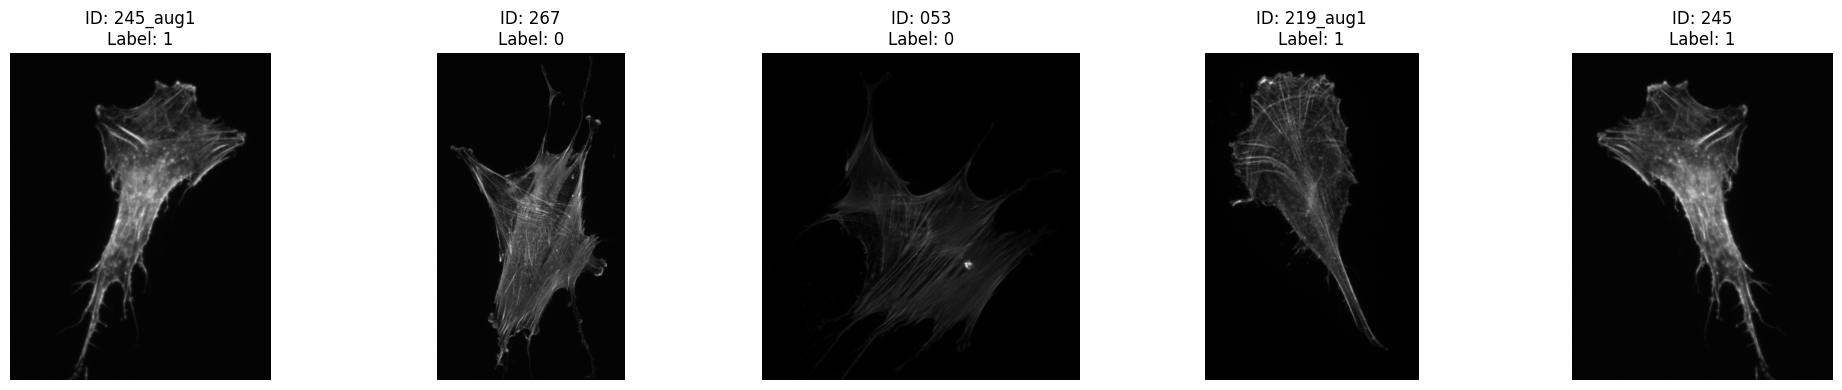

In [3]:
import os
import logging
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

# Set up logging
logging.basicConfig(level=logging.INFO)

# Function to load and preprocess data
def load_and_preprocess_data(csv_path, images_dir):
    df = pd.read_csv(csv_path)
    logging.info(f"Loaded dataframe with shape: {df.shape}")
    
    # Print column names to debug
    print("Column names:", df.columns.tolist())
    
    # Clean up the data
    df['image_id'] = df['image_id'].astype(str).str.strip()  # Adjust if there's a trailing space
    if 'is_homogenous' in df.columns:
        df['label'] = df['is_homogenous'].astype(int)
        df = df.drop(columns=['is_homogenous'])
    else:
        raise KeyError("Column 'is_homogenous' not found in the DataFrame.")
    
    def load_image(image_id):
        img_path = os.path.join(images_dir, f"{str(image_id).zfill(3)}.tif")
        if not os.path.exists(img_path):
            print(f"Warning: Image file not found: {img_path}")
            return None
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            print(f"Error: Unable to read image: {img_path}")
        return img
    
    df['image_array'] = df['image_id'].apply(load_image)
    
    # Count class distribution
    class_counts = df['label'].value_counts()
    logging.info(f"Class distribution: {class_counts.to_dict()}")
    
    return df, class_counts

# Load and preprocess data
csv_path = 'data/training_balanced.csv'
images_dir = 'data/training_balanced'
df, class_counts = load_and_preprocess_data(csv_path, images_dir)

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Log sizes of train and validation distributions
logging.info(f"Train set size: {len(train_df)}, Validation set size: {len(val_df)}")
logging.info(f"Train class distribution: {train_df['label'].value_counts().to_dict()}")
logging.info(f"Validation class distribution: {val_df['label'].value_counts().to_dict()}")
print(f"Train class distribution: {train_df['label'].value_counts().to_dict()}")
print(f"Validation class distribution: {val_df['label'].value_counts().to_dict()}")
print(f"Train set size: {len(train_df)}, Validation set size: {len(val_df)}")

# Function to display sample images
def show_samples(dataframe, num_samples=5):
    plt.figure(figsize=(20, 4))
    samples = dataframe.sample(num_samples)
    for i, (_, row) in enumerate(samples.iterrows()):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(row['image_array'], cmap='gray')
        plt.title(f"ID: {row['image_id']}\nLabel: {row['label']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()  # Changed from plt.savefig to plt.show()

# Show samples from the training set
print("Displaying sample images from the training set...")
show_samples(train_df)

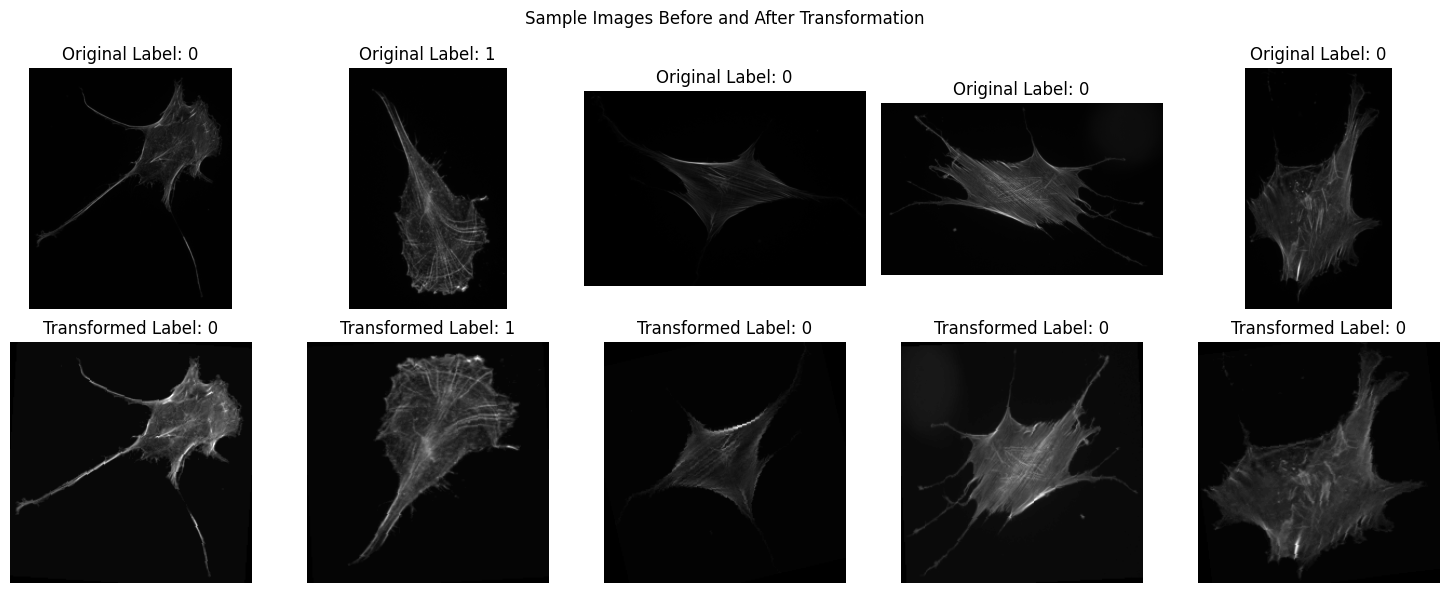

In [4]:
class CellDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # Filter out samples with None image_array
        self.dataframe = dataframe[dataframe['image_array'].notna()].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_array = self.dataframe.iloc[idx]['image_array']
        label = self.dataframe.iloc[idx]['label']
        
        if img_array is None:
            raise ValueError(f"Image at index {idx} is None.")
        
        # Convert numpy array to PIL Image
        if img_array.dtype == np.uint16:
            img_array = (img_array / 256).astype(np.uint8)
        elif img_array.dtype != np.uint8:
            img_array = ((img_array - img_array.min()) / (img_array.max() - img_array.min()) * 255).astype(np.uint8)
        
        img = Image.fromarray(img_array, mode='L')  # 'L' mode for grayscale
        
        # Apply transformations (including resize)
        if self.transform:
            img_transformed = self.transform(img)
        else:
            img_transformed = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])(img)
        
        # Verify the size of the transformed image
        if img_transformed.shape[1:] != (224, 224):
            raise ValueError(f"Transformed image has incorrect size: {img_transformed.shape}")
        
        return img_transformed, label

# The rest of your code remains the same
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

train_dataset = CellDataset(train_df, transform=transform)
val_dataset = CellDataset(val_df, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Plot sample images before and after transformation
def plot_samples(dataset, num_samples=5, title="Sample Images"):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        img_transformed, label = dataset[idx]
        
        # Get the original image from the dataframe
        img_original = dataset.dataframe.iloc[idx]['image_array']
        
        # Plot original image
        axes[0, i].imshow(img_original, cmap='gray')
        axes[0, i].set_title(f"Original Label: {label}")
        axes[0, i].axis('off')
        
        # Plot transformed image
        if isinstance(img_transformed, torch.Tensor):
            img_transformed = img_transformed.squeeze().numpy()
        axes[1, i].imshow(img_transformed, cmap='gray')
        axes[1, i].set_title(f"Transformed Label: {label}")
        axes[1, i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display sample images from the training set before and after transformation
plot_samples(train_dataset, title="Sample Images Before and After Transformation")


In [5]:
import os
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from torchvision.models import ResNet34_Weights
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

def calculate_custom_score(y_true, y_pred):
    n0 = sum(1 for label in y_true if label == 0)
    n1 = sum(1 for label in y_true if label == 1)
    a0 = sum(1 for true, pred in zip(y_true, y_pred) if true == 0 and pred == 0)
    a1 = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 1)
    return (a0 * a1) / (n0 * n1) if (n0 * n1) != 0 else 0

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=50, patience=10):
    device = next(model.parameters()).device
    train_losses, train_accuracies, train_scores = [], [], []
    val_losses, val_accuracies, val_scores = [], [], []
    
    best_custom_score = 0
    best_epoch = 0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_preds, all_train_labels = [], []

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_score = calculate_custom_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_scores.append(train_score)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_preds, all_val_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_score = calculate_custom_score(all_val_labels, all_val_preds)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_scores.append(val_score)

        # Learning rate scheduling
        scheduler.step(val_score)

        # Early stopping and model saving
        if val_score > best_custom_score:
            improvement = (val_score - best_custom_score) / best_custom_score * 100 if best_custom_score > 0 else 100
            best_custom_score = val_score
            best_epoch = epoch
            epochs_no_improve = 0
            torch.save(model.state_dict(), os.path.join(run_dir, 'best_model.pth'))
            logging.info(f"Epoch {epoch+1}: New best model saved! Validation score improved by {improvement:.2f}%")
        else:
            epochs_no_improve += 1
            logging.info(f"Epoch {epoch+1}: No improvement in validation score for {epochs_no_improve} epoch(s)")

        if epochs_no_improve == patience:
            logging.info(f'Early stopping triggered after epoch {epoch+1}')
            break

        # Logging
        logging.info(f"Epoch {epoch+1}/{num_epochs}")
        logging.info(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Score: {train_score:.4f}, F1: {train_f1:.4f}")
        logging.info(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Score: {val_score:.4f}, F1: {val_f1:.4f}")
        logging.info("-" * 50)

    logging.info(f"Training completed. Best model was saved at epoch {best_epoch+1} with validation score: {best_custom_score:.4f}")
    return train_losses, train_accuracies, train_scores, val_losses, val_accuracies, val_scores

def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    custom_score = calculate_custom_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, all_probs)
    
    return custom_score, f1, precision, recall, auc, all_labels, all_preds

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define model, loss function, optimizer, and scheduler
model = models.resnet34(weights=ResNet34_Weights.DEFAULT)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Train the model
num_epochs = 50
patience = 10

try:
    logging.info("Starting training...")
    train_losses, train_accuracies, train_scores, val_losses, val_accuracies, val_scores = train_model(
        model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs, patience=patience
    )
    logging.info("Training completed.")

    # Load the best model for evaluation
    model.load_state_dict(torch.load(os.path.join(run_dir, 'best_model.pth')))
    custom_score, f1, precision, recall, auc, all_labels, all_preds = evaluate_model(model, val_loader)

    # Log final metrics
    logging.info("Final Evaluation Results:")
    logging.info(f"Custom Score: {custom_score:.4f}")
    logging.info(f"F1 Score: {f1:.4f}")
    logging.info(f"Precision: {precision:.4f}")
    logging.info(f"Recall: {recall:.4f}")
    logging.info(f"ROC AUC: {auc:.4f}")

    # Determine if the model has learned
    if custom_score > 0.5 and f1 > 0.5:
        logging.info("The model has learned and shows good performance!")
    elif custom_score > 0.3 and f1 > 0.3:
        logging.info("The model has learned, but there's room for improvement.")
    else:
        logging.info("The model's performance is poor. Consider adjusting the architecture or training process.")

    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Heterogeneous', 'Homogeneous'], 
                yticklabels=['Heterogeneous', 'Homogeneous'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(os.path.join(run_dir, 'confusion_matrix.png'))
    plt.close()

    # Save Classification Report
    class_report = classification_report(all_labels, all_preds)
    with open(os.path.join(run_dir, 'classification_report.txt'), 'w') as f:
        f.write("Classification Report:\n")
        f.write(class_report)
        f.write(f"\nFinal Custom Score: {custom_score:.4f}")
        f.write(f"\nROC AUC: {auc:.4f}")

    # Plot training curves
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(train_scores, label='Train')
    plt.plot(val_scores, label='Validation')
    plt.title('Custom Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, 'training_curves.png'))
    plt.close()

    # Save metrics as CSV
    metrics_df = pd.DataFrame({
        'epoch': range(1, len(train_losses) + 1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies,
        'train_score': train_scores,
        'val_score': val_scores
    })
    metrics_df.to_csv(os.path.join(run_dir, 'metrics.csv'), index=False)

    # Save results as JSON
    results = {
        "custom_score": custom_score,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "roc_auc": auc,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "train_scores": train_scores,
        "val_scores": val_scores
    }
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)

    print(f"All outputs saved in the directory: {run_dir}")
    print("Training and evaluation completed.")

except Exception as e:
    logging.error(f"An error occurred during training or evaluation: {e}")
    raise

Using device: cpu


/Users/phongsakon/ai_comp_2024/DM-i-AI-2024/cell-classification-final/myenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2024-10-02 11:51:08,536 - INFO - Starting training...
Epoch 1/50: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]
2024-10-02 11:51:26,019 - INFO - Epoch 1: No improvement in validation score for 1 epoch(s)
2024-10-02 11:51:26,019 - INFO - Epoch 1/50
2024-10-02 11:51:26,020 - INFO - Train - Loss: 1.0849, Acc: 0.6013, Score: 0.3600, F1: 0.6008
2024-10-02 11:51:26,020 - INFO - Val   - Loss: 0.7934, Acc: 0.4872, Score: 0.0000, F1: 0.3192
2024-10-02 11:51:26,020 - INFO - --------------------------------------------------
Epoch 2/50: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]
2024-10-02 11:51:42,981 - INFO - Epoch 2: No improvement in validation score for 2 epoch(s)
2024-10-02 11:51:42,981 - INFO - Epoch 2/50
2024-10-02 11:51:42,981 - IN

All outputs saved in the directory: runs/resnet34_balanced_20241002_115106
Training and evaluation completed.
